In [1]:
import pandas as pd
import pandas.api.types as pdtypes
import numpy as np

from plotnine import *
#!pip install plydata
from plydata import *

In [2]:
data = pd.read_csv(
    'data/API_SP.DYN.IMRT.IN_DS2_en_csv_v2_1121327.csv',
    skiprows=[0, 1, 2])

# Columns as valid python variables
year_columns = {'y{}'.format(c): c for c in data.columns if c[:2] in {'19', '20'}}

data = (
    data    
    >> rename({'country': 'Country Name', 'code': 'Country Code'})
    >> rename(year_columns)
    >> select('Indicator Name', 'Indicator Code', 'Unnamed: 61', drop=True)
)

data >> head()

,country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,...,y2011,y2012,y2013,y2014,y2015,y2016,y2017,y2018,y2019,Unnamed: 64
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,236.5,232.6,228.9,225.1,221.4,217.7,213.9,...,61.9,59.5,57.3,55.1,53.1,51.2,49.5,47.9,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.5,67.3,63.6,60.5,57.8,55.5,53.4,51.6,NaN,NaN
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,10.2,9.5,8.9,8.5,8.2,8.0,7.8,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.7,3.6,3.4,3.2,3.1,3.0,2.8,2.7,NaN,NaN


In [3]:
metadata = pd.read_csv(
    'data/Metadata_Country_API_SP.DYN.IMRT.IN_DS2_en_csv_v2_1121327.csv'
)

metadata = (
    metadata
    >> rename({'code': 'Country Code',
               'region': 'Region',
               'income_group': 'IncomeGroup'
               })
    >> select('code', 'region', 'income_group')
)

cat_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
metadata['income_group'] = pd.Categorical(metadata['income_group'], categories=cat_order, ordered=True)

metadata >> head(10)

,code,region,income_group
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income
5,ARB,NaN,NaN
6,ARE,Middle East & North Africa,High income
7,ARG,Latin America & Caribbean,Upper middle income
8,ARM,Europe & Central Asia,Upper middle income
9,ASM,East Asia & Pacific,Upper middle income


In [4]:
# Drop the aggregates from
country_metadata = metadata >> call('.dropna', subset=['region'])
country_metadata >> head(10)

,code,region,income_group
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income
6,ARE,Middle East & North Africa,High income
7,ARG,Latin America & Caribbean,Upper middle income
8,ARM,Europe & Central Asia,Upper middle income
9,ASM,East Asia & Pacific,Upper middle income
10,ATG,Latin America & Caribbean,High income


In [5]:
country_data = inner_join(data, country_metadata, on='code')
country_data >> head()

,country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,...,y2013,y2014,y2015,y2016,y2017,y2018,y2019,Unnamed: 64,region,income_group
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean,High income
1,Afghanistan,AFG,NaN,236.5,232.6,228.9,225.1,221.4,217.7,213.9,...,57.3,55.1,53.1,51.2,49.5,47.9,NaN,NaN,South Asia,Low income
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.6,60.5,57.8,55.5,53.4,51.6,NaN,NaN,Sub-Saharan Africa,Lower middle income
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.5,8.9,8.5,8.2,8.0,7.8,NaN,NaN,Europe & Central Asia,Upper middle income
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.4,3.2,3.1,3.0,2.8,2.7,NaN,NaN,Europe & Central Asia,High income


In [6]:
sampled_data = (
    country_data
    >> call('.dropna', subset=['y1960', 'y2015'])
    >> sample_n(35, random_state=123)
    >> define(
        y1960_rank='y1960.rank(method="min").astype(int)',
        y2018_rank='y2018.rank(method="min").astype(int)'
    )
)

sampled_data >> head()

,country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,...,y2015,y2016,y2017,y2018,y2019,Unnamed: 64,region,income_group,y1960_rank,y2018_rank
68,United Kingdom,GBR,22.9,22.5,22.0,21.4,20.8,20.1,19.6,19.1,...,3.8,3.7,3.7,3.6,NaN,NaN,Europe & Central Asia,High income,5,6
148,New Zealand,NZL,22.5,21.7,20.9,20.0,19.3,18.7,18.3,17.9,...,4.9,4.9,4.8,4.7,NaN,NaN,East Asia & Pacific,High income,4,8
25,Bolivia,BOL,175.2,172.0,168.9,165.7,162.6,159.4,156.1,152.9,...,24.9,23.8,22.8,21.8,NaN,NaN,Latin America & Caribbean,Lower middle income,30,18
215,Zambia,ZMB,122.2,119.9,117.9,116.2,114.8,113.8,113.0,112.4,...,44.5,43.1,41.5,40.4,NaN,NaN,Sub-Saharan Africa,Lower middle income,18,27
5,United Arab Emirates,ARE,134.1,127.8,121.7,115.7,109.4,103.0,96.3,89.7,...,6.7,6.6,6.6,6.5,NaN,NaN,Middle East & North Africa,High income,22,9


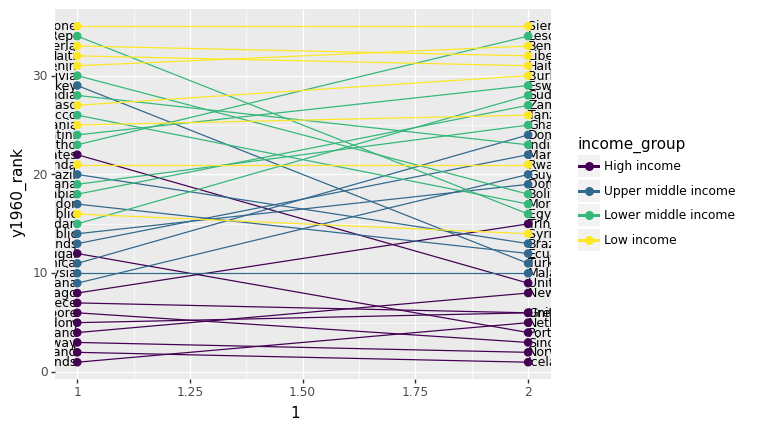

<ggplot: (-9223371953349518288)>

In [7]:
(ggplot(sampled_data)
 + geom_text(aes(1, 'y1960_rank', label='country'), ha='right', size=9)
 + geom_text(aes(2, 'y2018_rank', label='country'), ha='left', size=9)
 + geom_point(aes(1, 'y1960_rank', color='income_group'), size=2.5)
 + geom_point(aes(2, 'y2018_rank', color='income_group'), size=2.5)
 + geom_segment(aes(x=1, y='y1960_rank', xend=2, yend='y2018_rank', color='income_group'))
)

In [8]:
# Text colors
black1 = '#252525'
black2 = '#222222'

p=(ggplot(sampled_data)
 # Slight modifications for the original lines,
 # 1. Nudge the text to either sides of the points
 # 2. Alter the color and alpha values
 + geom_text(aes(1, 'y1960_rank', label='country'), nudge_x=-0.05, ha='right', size=9, color=black1)
 + geom_text(aes(2, 'y2018_rank', label='country'), nudge_x=0.05, ha='left', size=9, color=black1)
 + geom_point(aes(1, 'y1960_rank', color='income_group'), size=2.5, alpha=.7)
 + geom_point(aes(2, 'y2018_rank', color='income_group'), size=2.5, alpha=.7)
 + geom_segment(aes(x=1, y='y1960_rank', xend=2, yend='y2018_rank', color='income_group'), alpha=.7)
 
 # Text Annotations
 + annotate('text', x=1, y=0, label='Rank in 1960', fontweight='bold', ha='right', size=10, color=black2)
 + annotate('text', x=2, y=0, label='Rank in 2018', fontweight='bold', ha='left', size=10, color=black2)
 + annotate('text', x=1.5, y=0, label='Lines show change in rank', size=9, color=black1)
 + annotate('label', x=1.5, y=3, label='Lower infant\ndeath rates', size=9, color=black1,
            label_size=0, fontstyle='italic')
 + annotate('label', x=1.5, y=33, label='Higher infant\ndeath rates', size=9, color=black1,
            label_size=0, fontstyle='italic')
 
 # Prevent country names from being chopped off
 + lims(x=(0.35, 2.65))
 + labs(color='Income Group')
 # Countries with lower rates on top
 + scale_y_reverse()
 # Change colors
 + scale_color_brewer(type='qual', palette=2)
 # Removes all decorations
 + theme_void()
 # Changing the figure size prevents the country names from squishing up
 + theme(figure_size=(8, 11))
)
ggsave(p,device='jpg',filename='figure-100%.jpg')

C:\Users\Diogo\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 11 in image.
C:\Users\Diogo\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figure-100%.jpg
